# [**Segmenter en régions l'image des pièces de monnaie grecques**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/2_3_cluster/plot_coin_segmentation.ipynb)<br/>([*Segmenting the picture of greek coins in regions*](https://scikit-learn.org/stable/auto_examples/cluster/plot_coin_segmentation.html))

Cet exemple utilise le [**Regroupement spectral** (2.3.5)](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) sur un graphe créé à partir des différences voxel à voxel sur une image pour diviser cette image en plusieurs régions partiellement homogènes.

Cette procédure (regroupement spectral sur une image) est une solution approchée efficace pour trouver des coupes de graphe normalisées.

Il existe trois options pour attribuer des étiquettes :
* le regroupement spectral 'kmeans' regroupe les échantillons dans l'espace de plongement en utilisant un algorithme kmeans
* 'discrete' recherche itérativement l'espace de partition le plus proche de l'espace de plongement du regroupement spectral.
* 'cluster_qr' attribue des étiquettes à l'aide de la factorisation QR avec pivotement qui détermine directement la partition dans l'espace de plongement.

In [5]:
# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>
#         Brian Cheung
#         Andrew Knyazev <Andrew.Knyazev@ucdenver.edu>
# License: BSD 3 clause

import time

import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering


# load the coins as a numpy array
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", anti_aliasing=False)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(rescaled_coins)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# The number of segmented regions to display needs to be chosen manually.
# The current version of 'spectral_clustering' does not support determining
# the number of good quality clusters automatically.
n_regions = 26

Calculer et visualiser les régions résultantes

Spectral clustering: kmeans, 4.04s
Spectral clustering: discretize, 3.31s
Spectral clustering: cluster_qr, 3.36s


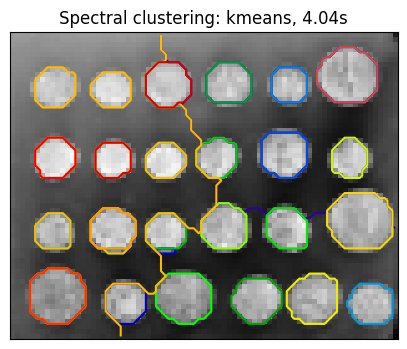

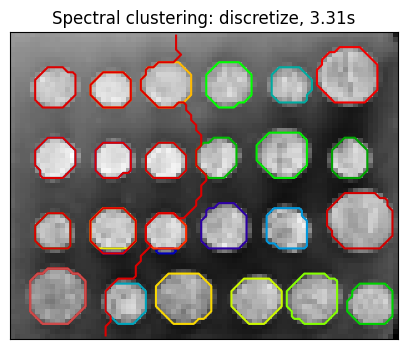

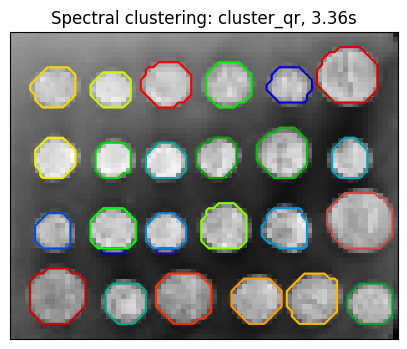

In [6]:
# Computing a few extra eigenvectors may speed up the eigen_solver.
# The spectral clustering quality may also benetif from requesting
# extra regions for segmentation.
n_regions_plus = 3

# Apply spectral clustering using the default eigen_solver='arpack'.
# Any implemented solver can be used: eigen_solver='arpack', 'lobpcg', or 'amg'.
# Choosing eigen_solver='amg' requires an extra package called 'pyamg'.
# The quality of segmentation and the speed of calculations is mostly determined
# by the choice of the solver and the value of the tolerance 'eigen_tol'.
# TODO: varying eigen_tol seems to have no effect for 'lobpcg' and 'amg' #21243.
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
plt.show()

# TODO: After #21194 is merged and #21243 is fixed, check which eigen_solver
# is the best and set eigen_solver='arpack', 'lobpcg', or 'amg' and eigen_tol
# explicitly in this example.